In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

model = tf.keras.models.load_model('best.hdf5')
model.trainable = False
model.training = False

In [2]:
# loading the face detector from opencv
modelFile = "res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

0.11586713790893555


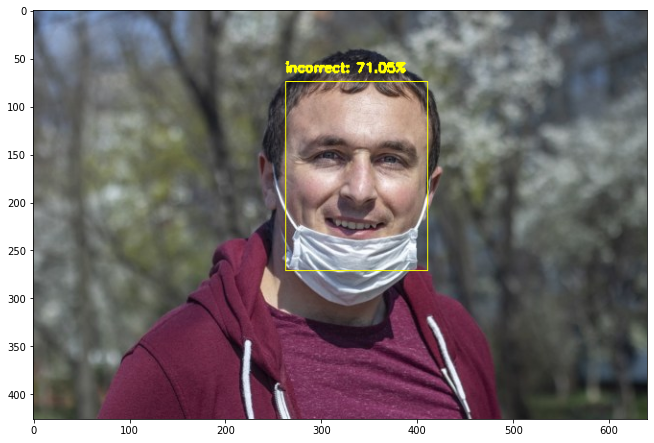

In [3]:
image_path = 'testing.jpg'

#reading the image
image = cv2.imread(image_path)

# The mean values are according to train.prototxt for the model
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
net.setInput(blob)
start = time.time()
# Face detection
detections = net.forward()
end = time.time()
print(end-start)

classes = [
        {'class': 'correct', 'color': (0, 255, 0)}, 
        {'class': 'incorrect', 'color': (255, 255, 0)}, 
        {'class': 'no mask', 'color': (255, 0, 0)}
]


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_orig = image.copy()

h, w, _ = image.shape
faces = []
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
        box = detections[0, 0, i, 3:]
        box = box * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        if startX < 0 or startY < 0 or endX > w or endY >h:
            continue

        face = image_orig[startY:endY, startX:endX]
        resized_face = cv2.resize(face, (224, 224))
        resized_face = resized_face.reshape((-1, 224, 224, 3))
        max_index = model.predict(resized_face).argmax(axis=1)[0]
        confidence = model.predict(resized_face)[0, max_index]
        dic = classes[max_index]
        cat = dic['class']
        color = dic['color']

        text = "{}: {:.2f}%".format(cat, confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10 # position of text

        cv2.rectangle(image, (startX, startY), (endX, endY), color, 1)
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

plt.figure(figsize=(11, 11))
plt.imshow(image)